In [ ]:
# improt the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
!pip install tabulate
from tabulate import tabulate
import os
import matplotlib.image as mpimg
import random
import cv2

pd.set_option('display.max_columns', None)

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def create_dataframe_from_images(image_folder_path):
    image_paths = []

    # Count total files to set up tqdm
    total_files = sum(len(files) for _, _, files in os.walk(image_folder_path))

    with tqdm(total=total_files, desc="Processing images") as pbar:
        for root, dirs, files in os.walk(image_folder_path):
            for file in files:
                if file.endswith(".jpg") or file.endswith(".jpeg"):
                    image_paths.append(os.path.join(root, file))
                    pbar.update(1)

    data = {'Image_Path': image_paths}
    df = pd.DataFrame(data)
    return df

In [ ]:
folder_path = '/content/drive/MyDrive/Hands Dataset/Dataset'
dataset = create_dataframe_from_images(folder_path)
dataset.head()

Processing images:   0%|          | 0/30576 [00:00<?, ?it/s]

Image_Path
0  /content/drive/MyDrive/Hands Dataset/Dataset/2...
1  /content/drive/MyDrive/Hands Dataset/Dataset/2...
2  /content/drive/MyDrive/Hands Dataset/Dataset/2...
3  /content/drive/MyDrive/Hands Dataset/Dataset/2...
4  /content/drive/MyDrive/Hands Dataset/Dataset/2...

In [ ]:
dataset_org = dataset.copy()

In [ ]:
dataset['Image_Path__'] = dataset['Image_Path'].apply(lambda x: x.replace("/Augmented", ""))

In [ ]:
dataset['age'] = dataset['Image_Path__'].apply(lambda x: x.split("/")[-2]).astype(int)
dataset.head()

Image_Path  \
0  /content/drive/MyDrive/Hands Dataset/Dataset/2...   
1  /content/drive/MyDrive/Hands Dataset/Dataset/2...   
2  /content/drive/MyDrive/Hands Dataset/Dataset/2...   
3  /content/drive/MyDrive/Hands Dataset/Dataset/2...   
4  /content/drive/MyDrive/Hands Dataset/Dataset/2...   

                                        Image_Path__  age  
0  /content/drive/MyDrive/Hands Dataset/Dataset/2...   27  
1  /content/drive/MyDrive/Hands Dataset/Dataset/2...   27  
2  /content/drive/MyDrive/Hands Dataset/Dataset/2...   27  
3  /content/drive/MyDrive/Hands Dataset/Dataset/2...   27  
4  /content/drive/MyDrive/Hands Dataset/Dataset/2...   27

In [ ]:
df_info = pd.read_csv("/content/drive/MyDrive/Hands Dataset/HandInfo.csv")
df_info.head()

id  age gender skinColor  accessories  nailPolish  aspectOfHand  \
0   0   27   male      fair            0           0  dorsal right   
1   0   27   male      fair            0           0  dorsal right   
2   0   27   male      fair            0           0  dorsal right   
3   0   27   male      fair            0           0  dorsal right   
4   0   27   male      fair            0           0  dorsal right   

          imageName  irregularities  
0  Hand_0000002.jpg               0  
1  Hand_0000003.jpg               0  
2  Hand_0000004.jpg               0  
3  Hand_0000005.jpg               0  
4  Hand_0000006.jpg               0

In [ ]:
# check number of persons per age
df_no_person_per_age = df_info.groupby('age')['id'].nunique().to_frame().reset_index().rename(columns={'id': 'no_person_per_age'})
df_no_person_per_age

age  no_person_per_age
0    18                  1
1    19                  2
2    20                 39
3    21                 80
4    22                 36
5    23                 16
6    24                  2
7    25                  2
8    26                  2
9    27                  1
10   28                  1
11   29                  1
12   30                  1
13   36                  1
14   43                  1
15   54                  1
16   70                  1
17   75                  1

In [ ]:
# Filter the DataFrame to get ages where the number of people per age is >= 2
grouped_ages = df_no_person_per_age[df_no_person_per_age['no_person_per_age'] >= 2]['age'].values.tolist()
print(grouped_ages)

[19, 20, 21, 22, 23, 24, 25, 26]


In [ ]:
dataset_new = dataset[dataset['age'].isin(grouped_ages)]

In [ ]:
# Define a function to get the first 795 rows from each group
def get_first_795(group):
    return group.head(795)

grouped_dataset = dataset_new.groupby('age').apply(get_first_795)
grouped_dataset = grouped_dataset.reset_index(drop=True)
grouped_dataset.head()

Image_Path  \
0  /content/drive/MyDrive/Hands Dataset/Dataset/1...   
1  /content/drive/MyDrive/Hands Dataset/Dataset/1...   
2  /content/drive/MyDrive/Hands Dataset/Dataset/1...   
3  /content/drive/MyDrive/Hands Dataset/Dataset/1...   
4  /content/drive/MyDrive/Hands Dataset/Dataset/1...   

                                        Image_Path__  age  
0  /content/drive/MyDrive/Hands Dataset/Dataset/1...   19  
1  /content/drive/MyDrive/Hands Dataset/Dataset/1...   19  
2  /content/drive/MyDrive/Hands Dataset/Dataset/1...   19  
3  /content/drive/MyDrive/Hands Dataset/Dataset/1...   19  
4  /content/drive/MyDrive/Hands Dataset/Dataset/1...   19

In [ ]:
grouped_dataset['age'].value_counts()

age
19    795
20    795
21    795
22    795
23    795
24    795
25    795
26    795
Name: count, dtype: int64

In [ ]:
def check_distribution(dataset):
  # Distribution of Age
  plt.figure(figsize=(15, 6))
  sns.countplot(data=dataset, x='age', palette='Set3')
  plt.title('Count Plot by Age')
  plt.xlabel('Age')
  plt.ylabel('Count')

  ax = plt.gca()
  for p in ax.patches:
      ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

  plt.show()

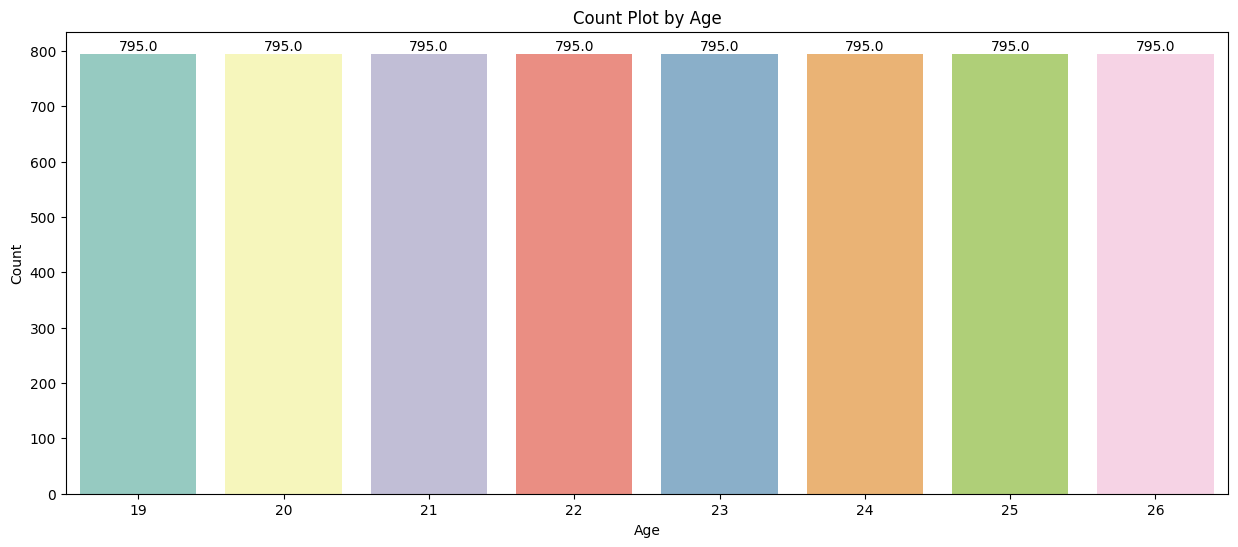

In [ ]:
check_distribution(grouped_dataset)

In [ ]:
df = grouped_dataset.copy()

In [ ]:
df.shape

(6360, 3)

In [ ]:
# Write a function that will select n random images and display images along with its Age
def plot_random_images(df, total_image=2):
    fig, axes = plt.subplots(1, total_image,figsize=(14,2))
    images_data = list(zip(df['Image_Path'],df['age']))
    samples = random.sample(images_data,total_image)
    for ax, (image, label) in zip(axes, samples):
        image = mpimg.imread(image)
        ax.set_axis_off()
        ax.imshow(image, cmap = 'binary')
        ax.set_title(f'{label}')

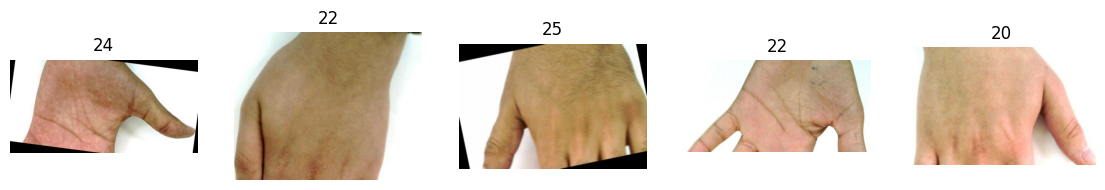

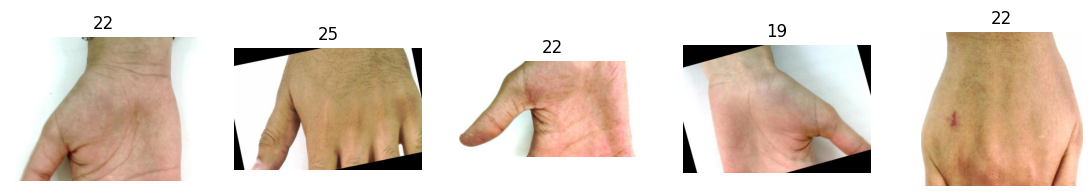

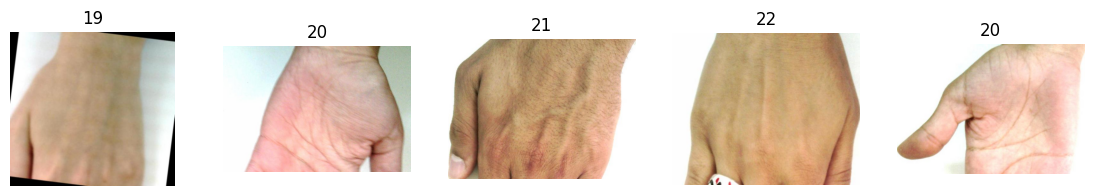

In [ ]:
# plot original dataset random images
plot_random_images(df, 5)
plot_random_images(df, 5)
plot_random_images(df, 5)

In [ ]:
from keras.applications.densenet import DenseNet201
from tensorflow.keras.preprocessing.image import img_to_array

### **Save Images Data into Numpy Arrays**

In [ ]:
width = 50
height = 50

In [ ]:
def get_images_data_arrays(df):
  data = []
  labels = []
  for img, age in tqdm(list(zip(df['Image_Path'], df['age']))):
      try:
          img_read = plt.imread(img)
          if len(img_read.shape) == 2:
              img_read = cv2.cvtColor(img_read, cv2.COLOR_GRAY2RGB)
          elif len(img_read.shape) == 3:
              img_read = cv2.cvtColor(img_read, cv2.COLOR_BGR2RGB)
          img_resize = cv2.resize(img_read, (width, height))
          img_array = img_to_array(img_resize)

          # Normalize the image
          img_array /= 255.0

          data.append(img_array)
          labels.append(age)
      except:
          None
  return np.array(data), np.array(labels)

In [ ]:
image_data, labels = get_images_data_arrays(df)

  0%|          | 0/6360 [00:00<?, ?it/s]

In [ ]:
len(image_data)

6360

In [ ]:
np.save('/content/drive/MyDrive/Hands Dataset/images', image_data)
np.save('/content/drive/MyDrive/Hands Dataset/labels', labels)

### **load data from numpy file**

In [ ]:
image_data = np.load('/content/drive/MyDrive/Hands Dataset/images.npy')
labels = np.load('/content/drive/MyDrive/Hands Dataset/labels.npy')

# <font color='magma'> **Features Extraction through CNN (DenseNet201)**

* To extract features from our hand dataset, we can leverage a Convolutional Neural Network (CNN) architecture called DenseNet201. By utilizing DenseNet201, we can benefit from its deep layers and dense connections that enable effective feature extraction. We pass the hand images through the pre-trained DenseNet201 model, which captures high-level representations of the input data. The output of the model serves as the extracted features, which can then be used for various tasks such as hand gesture recognition, object detection, or further analysis. The extracted features from DenseNet201 provide a rich representation of the hand images, enabling more robust and accurate downstream tasks.

In [ ]:
model = DenseNet201(weights='imagenet',input_shape=(width,height,3), include_top=False)
# don't train existing weights
for layer in model.layers:
  layer.trainable = False

74836368/74836368 [==============================] - 0s 0us/step


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.476424 to fit



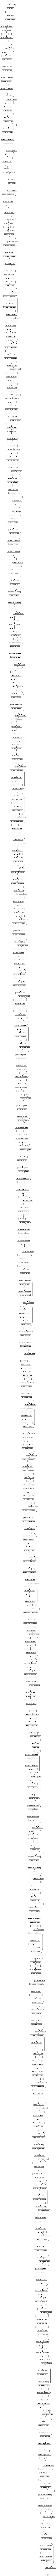

<Figure size 500x1000 with 0 Axes>

In [ ]:
from tensorflow.keras.utils import to_categorical, plot_model
plt.figure(figsize=(5, 10))
plot_model(model, to_file="model.png")

In [ ]:
feature_extractor = model.predict(image_data)

199/199 [==============================] - 15s 30ms/step


In [ ]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

In [ ]:
cols = ['feature_'+str(i) for i in range(features.shape[1])]

In [ ]:
# make a dataframe
df_data = pd.DataFrame(features, columns=cols)
df_data['label'] = labels

In [ ]:
df_data.sample()

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
5976   0.000236   0.001571        0.0   0.005829   0.003038   0.000318   

      feature_6  feature_7  feature_8  feature_9  feature_10  feature_11  \
5976   0.000728        0.0   0.000752   0.012577      0.0029    0.001507   

      feature_12  feature_13  feature_14  feature_15  feature_16  feature_17  \
5976         0.0    0.002258    0.006489         0.0         0.0    0.000438   

      feature_18  feature_19  feature_20  feature_21  feature_22  feature_23  \
5976    0.000232         0.0         0.0    0.000293    0.001056    0.027726   

      feature_24  feature_25  feature_26  feature_27  feature_28  feature_29  \
5976     0.00038         0.0         0.0    0.000161         0.0    0.000324   

      feature_30  feature_31  feature_32  feature_33  feature_34  feature_35  \
5976         0.0    0.001005    0.000071         0.0    0.011391    0.000616   

      feature_36  feature_37  feature_38  feature_39  feature_40  feature_41  \
5976    0.000789         0.0    0.000292    0.000275         0.0     0.00038   

      feature_42  feature_43  feature_44  feature_45  feature_46  feature_47  \
5976         0.0         0.0         0.0         0.0         0.0         0.0   

      feature_48  feature_49  feature_50  feature_51  feature_52  feature_53  \
5976    0.000425    0.000157         0.0         0.0    0.000684    0.265022   

      feature_54  feature_55  feature_56  feature_57  feature_58  feature_59  \
5976    0.032777    0.000171     0.00025    0.000297         0.0    0.000684   

      feature_60  feature_61  feature_62  feature_63  feature_64  feature_65  \
5976         0.0         0.0    0.000026         0.0         0.0    0.004541   

      feature_66  feature_67  feature_68  feature_69  feature_70  feature_71  \
5976    0.000063    0.000263    0.000383    0.000658    0.001566    0.001811   

      feature_72  feature_73  feature_74  feature_75  feature_76  feature_77  \
5976    0.000696         0.0         0.0         0.0    0.000153         0.0   

      feature_78  feature_79  feature_80  feature_81  feature_82  feature_83  \
5976    0.002043    0.000468    0.001286     0.02623    0.001849         0.0   

      feature_84  feature_85  feature_86  feature_87  feature_88  feature_89  \
5976    0.005008    0.008064         0.0         0.0         0.0         0.0   

      feature_90  feature_91  feature_92  feature_93  feature_94  feature_95  \
5976         0.0         0.0    0.000887    0.000049         0.0    0.006483   

      feature_96  feature_97  feature_98  feature_99  feature_100  \
5976    0.000884    0.006707    0.000188    0.000261     0.008318   

      feature_101  feature_102  feature_103  feature_104  feature_105  \
5976     0.002564          0.0     0.133385     0.000182     0.000263   

      feature_106  feature_107  feature_108  feature_109  feature_110  \
5976     0.005767          0.0          0.0          0.0          0.0   

      feature_111  feature_112  feature_113  feature_114  feature_115  \
5976     0.005509          0.0     0.001272          0.0     0.000162   

      feature_116  feature_117  feature_118  feature_119  feature_120  \
5976     0.002775     0.000199          0.0     0.000723          0.0   

      feature_121  feature_122  feature_123  feature_124  feature_125  \
5976          0.0     0.017438     0.006184     0.003922     0.010366   

      feature_126  feature_127  feature_128  feature_129  feature_130  \
5976          0.0          0.0     0.002347     0.003416          0.0   

      feature_131  feature_132  feature_133  feature_134  feature_135  \
5976          0.0          0.0     0.000199     0.001021          0.0   

      feature_136  feature_137  feature_138  feature_139  feature_140  \
5976     0.000115          0.0          0.0     0.016909     0.000323   

      feature_141  feature_142  feature_143  feature_144  feature_145  \
5976     0.000009     0.006705          0.0     0.000231     0

In [ ]:
df_data.shape

(6360, 1921)

In [ ]:
df_data.to_csv("/content/drive/MyDrive/Hands Dataset/features_extraction.csv", index=False)
print("data saved.")

data saved.


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Hands Dataset/features_extraction.csv")
df.head()

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.000066   0.001889   0.003523   0.004614   0.002422   0.000555   
1   0.000000   0.000587   0.001297   0.007064   0.000840   0.001015   
2   0.000000   0.001219   0.001419   0.009937   0.002184   0.000593   
3   0.000277   0.001915   0.001925   0.010816   0.003309   0.000702   
4   0.000000   0.001579   0.001386   0.008837   0.001949   0.000662   

   feature_6  feature_7  feature_8  feature_9  feature_10  feature_11  \
0   0.000000   0.000000   0.000345   0.026857    0.000000    0.005581   
1   0.001241   0.000310   0.000298   0.022236    0.000000    0.010766   
2   0.000000   0.000000   0.000290   0.000000    0.000698    0.008844   
3   0.000000   0.000000   0.000202   0.030780    0.000697    0.003233   
4   0.000000   0.000264   0.000297   0.000000    0.000825    0.009642   

   feature_12  feature_13  feature_14  feature_15  feature_16  feature_17  \
0    0.000000    0.002551    0.020501    0.000000    0.000000    0.000453   
1    0.000000    0.005616    0.023845    0.000000    0.001092    0.000508   
2    0.000404    0.000000    0.020131    0.000129    0.000543    0.000126   
3    0.000308    0.000000    0.011454    0.000286    0.000031    0.000000   
4    0.000569    0.000000    0.018921    0.000098    0.000154    0.000033   

   feature_18  feature_19  feature_20  feature_21  feature_22  feature_23  \
0    0.000000    0.001114    0.000000    0.000000    0.002108    0.009720   
1    0.000000    0.000000    0.000005    0.000358    0.000151    0.034165   
2    0.001906    0.000000    0.000005    0.000000    0.000693    0.043562   
3    0.000443    0.000000    0.000018    0.000000    0.000271    0.037661   
4    0.002117    0.000000    0.000010    0.000000    0.000685    0.043022   

   feature_24  feature_25    feature_26  feature_27  feature_28  feature_29  \
0    0.001035    0.000000  0.000000e+00    0.000295    0.000391    0.000245   
1    0.000053    0.000174  9.251334e-06    0.000088    0.000000    0.000002   
2    0.000000    0.000192  4.410883e-07    0.000194    0.000392    0.000143   
3    0.000000    0.000408  0.000000e+00    0.000632    0.000000    0.000131   
4    0.000000    0.000231  2.012560e-06    0.000242    0.000077    0.000120   

   feature_30  feature_31  feature_32  feature_33  feature_34  feature_35  \
0         0.0    0.000220    0.000568    0.000000    0.014874    0.000883   
1         0.0    0.000536    0.000688    0.000000    0.024926    0.002340   
2         0.0    0.000299    0.000566    0.000000    0.003409    0.001778   
3         0.0    0.001030    0.000803    0.005797    0.006274    0.000837   
4         0.0    0.000213    0.000898    0.000000    0.006117    0.001566   

   feature_36  feature_37  feature_38  feature_39  feature_40  feature_41  \
0    0.003423    0.001050    0.000000    0.000213    0.000101    0.000000   
1    0.000674    0.000269    0.000216    0.000532    0.000191    0.000406   
2    0.001276    0.002962    0.000000    0.000000    0.000158    0.000000   
3    0.002221    0.000000    0.000322    0.000807    0.000357    0.000163   
4    0.000981    0.001955    0.000000    0.000000    0.000307    0.000000   

   feature_42  feature_43  feature_44  feature_45  feature_46  feature_47  \
0    0.000046    0.000000    0.000000         0.0    0.000841    0.000628   
1    0.000172    0.000000    0.000002         0.0    0.000000    0.000257   
2    0.000000    0.022036    0.000000         0.0    0.000000    0.000000   
3    0.000141    0.023945    0.000000         0.0    0.000000    0.000000   
4    0.000000    0.019510    0.000000         0.0    0.000000    0.000000   

   feature_48  feature_49  feature_50  feature_51  feature_52  feature_53  \
0    0.000598    0.000000    0.000000    0.000000    0.000000    0.382089   
1    0.000363    0.001616    0.000344    0.000008    0.000207    0.355496   
2    0.000216    0.000050    0.000000    0.000000    0.000382    0.201788   
3    0.000368    0.000000    0.000000  

In [ ]:
X = df.drop('label', axis = 1).values
y = df['label'].values

# <font color='magma'> **PCA**
* Principal Component Analysis (PCA) is a popular technique for dimensionality reduction and feature extraction. It transforms original features into a new set of orthogonal components, known as principal components, which capture the most significant variance in the data. In the context of hand image feature extraction, PCA can reduce the complexity of the feature space while retaining essential hand pose or gesture information. By applying PCA to the extracted features from DenseNet201, we can further decrease dimensionality while preserving important information.

In [ ]:
from sklearn.decomposition import PCA

# Dimensionaly Reduction
pca = PCA()
X_pca_reduced = pca.fit_transform(X)

In [ ]:
def plot_cumm_var(pca, dataset_name, threshold=None):
    pc_list = ["PC"+str(i) for i in list(range(1, len(pca.explained_variance_ratio_.tolist())+1))]
    pca_variance = np.cumsum(pca.explained_variance_ratio_.tolist())
    pca_df = pd.DataFrame({'pca_feature':pc_list,'cummulative variance':pca_variance})
    pca_df = pca_df[pca_df['cummulative variance']<=threshold]
    pca_df['cummulative variance'] = round(pca_df['cummulative variance']*100,2)
    # print(tabulate(pca_df, headers = 'keys', tablefmt = 'psql'))
    plt.figure(figsize=(15,5))
    plt.plot(pc_list,pca_variance,c='red',marker='X', linewidth=2,markersize=9)
    if threshold:
        # Draw line set threshold
        value99 = pca_variance[-1]*threshold
        plt.hlines(y = value99, xmin=0, xmax=len(pca.explained_variance_ratio_.tolist()), color = 'r', linestyles = 'dashed')
    plt.title(f"PCA Variance Graph ({dataset_name} Dataset) - Total Best Feature {len(pca_df)}", fontsize=18)
    plt.xlabel("PCs",fontsize=18)
    plt.ylabel("Cummulative Variance",fontsize=18)
    plt.xticks(rotation=90)
    plt.grid(False)
    plt.savefig(f"PCA.png", bbox_inches='tight')
    plt.show()
    print("Final Total Feature We will use for PCA is {}".format(len(pca_df)))
    return len(pca_df)

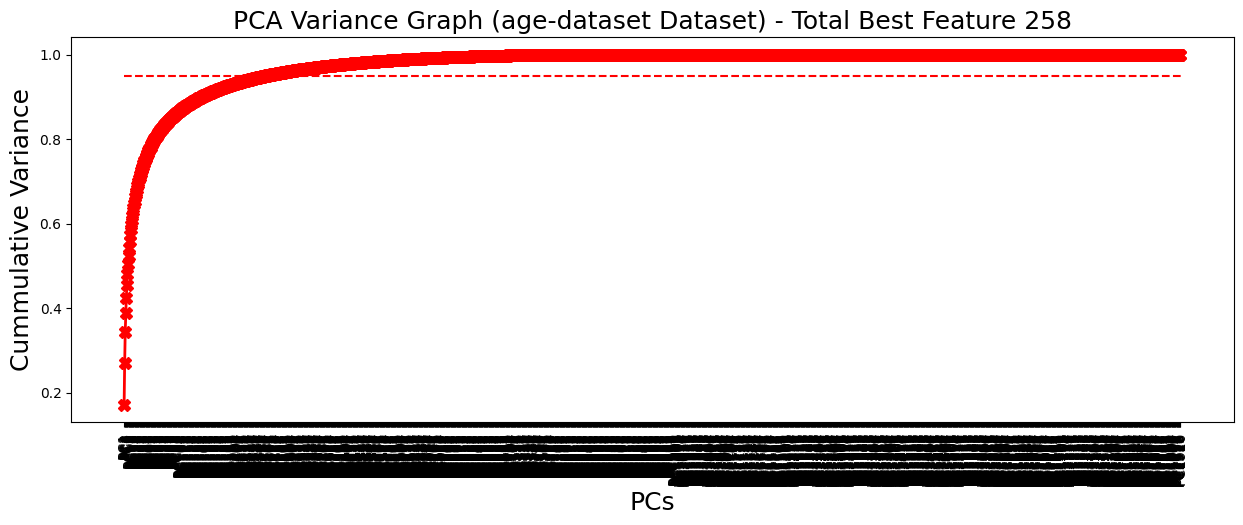

Final Total Feature We will use for PCA is 258


In [ ]:
# lets Draw a horizontal line on the above plot to highlight the threshold of 95%.
total_best_pca = plot_cumm_var(pca, 'age-dataset', threshold=0.95)

In [ ]:
pca = PCA(n_components=total_best_pca)
# pass our X to the pca and store the reduced vectors into data_pca
data_pca = pca.fit_transform(X)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.auto import tqdm

### Function kfold_crossvalidation
* The kfold_crossvalidation function code implements a k-fold cross-validation procedure for evaluating a given model using a specified number of splits and iterations. The goal is to assess the performance of the model on the provided dataset.

* In each iteration, the dataset is divided into k folds using StratifiedKFold, ensuring that the class distribution is maintained. The model is then trained and evaluated on each fold. The evaluation metrics used include Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared score (R2).

* For each fold, the model is trained on the training data and predictions are made on the corresponding test data. The resulting predictions are compared against the actual target values to compute the evaluation metrics. These metrics are stored for each fold and iteration.

* After completing all the iterations, the results from each fold are aggregated. The average MSE, RMSE, and R2 score are calculated across all folds for each iteration, providing a comprehensive assessment of the model's performance.

* The final results are stored in separate DataFrames, results_df and results_df_avg, which contain the evaluation metrics for each fold and iteration. The DataFrames are then concatenated and returned as the output of the kfold_crossvalidation function.

In [ ]:
def kfold_crossvalidation(X, y, model, n_splits=5, iteration=5):
  final_res = []
  final_res_avg = []

  for iter in range(iteration):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_number = 1

    store_res = []

    MSE = []
    RMSE = []
    R2 = []

    for train_index, test_index in tqdm(skf.split(X, y), desc=f"Model: {model.__class__.__name__} - Iteration:{iter+1}", total=n_splits):
        # Split data into training and testing sets for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit model on the training data
        model.fit(X_train, y_train)

        # Predict using the model
        y_pred = model.predict(X_test)

        # Compute MSE, RMSE, and R2 score
        mse = mean_squared_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)

        MSE.append(mse)
        RMSE.append(rmse)
        R2.append(r2)

        fold_results = [{"Model": model.__class__.__name__, "Fold": fold_number, "MSE": mse, "RMSE": rmse, "R2 Score": r2, 'Iteration':iter+1}]
        results_df = pd.DataFrame(fold_results)
        store_res.append(results_df)

        fold_number += 1

    fold_results = [{"Model": model.__class__.__name__, 'Iteration':iter+1, "MSE": np.mean(MSE), "RMSE": np.mean(RMSE), "R2 Score": np.mean(R2)}]
    results_df_avg = pd.DataFrame(fold_results)
    final_res_avg.append(results_df_avg)

    results_df = pd.concat(store_res)
    final_res.append(results_df)
  results_df = pd.concat(final_res)
  results_df_avg = pd.concat(final_res_avg)

  return results_df.reset_index(drop=True), results_df_avg.reset_index(drop=True)

# RandomForestRegressor

In [ ]:
params = {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error',
          'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
          'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0,
          'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
model = RandomForestRegressor(**params)

RandomForestRegressor()

In [ ]:
res_rf, res_avg_rf = kfold_crossvalidation(data_pca, y, model)

Model: RandomForestRegressor - Iteration:1:   0%|          | 0/5 [00:00<?, ?it/s]

Model: RandomForestRegressor - Iteration:2:   0%|          | 0/5 [00:00<?, ?it/s]

Model: RandomForestRegressor - Iteration:3:   0%|          | 0/5 [00:00<?, ?it/s]

Model: RandomForestRegressor - Iteration:4:   0%|          | 0/5 [00:00<?, ?it/s]

Model: RandomForestRegressor - Iteration:5:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
def save_results_file(results_df, results_df_avg, model_name):
  results_df.to_csv(f"/content/drive/MyDrive/Hands Dataset/Results/{model_name}_results.csv", index=False)
  results_df_avg.to_csv(f"/content/drive/MyDrive/Hands Dataset/Results/{model_name}_results_avg.csv", index=False)
  print("Results saved successfully!")

In [ ]:
save_results_file(res_rf, res_avg_rf, "RandomForest")

Results saved successfully!


# LGBMRegressor

In [ ]:
params = {'boosting_type': 'gbdt', 'class_weight': None,
          'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1,
          'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
          'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None,
          'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
model = LGBMRegressor(**params)

In [ ]:
res_rf, res_avg_rf = kfold_crossvalidation(data_pca, y, model)
save_results_file(res_rf, res_avg_rf, "LGBMRegressor")

Model: LGBMRegressor - Iteration:1:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65790
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 258
[LightGBM] [Info] Start training from score 22.500000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65790
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 258
[LightGBM] [Info] Start training from score 22.500000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65790
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 258
[LightGBM] [Info] Star

Model: LGBMRegressor - Iteration:2:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65790
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 258
[LightGBM] [Info] Start training from score 22.500000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65790
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 258
[LightGBM] [Info] Start training from score 22.500000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65790
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 258
[LightGBM] [Info] Star

Model: LGBMRegressor - Iteration:3:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65790
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 258
[LightGBM] [Info] Start training from score 22.500000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65790
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 258
[LightGBM] [Info] Start training from score 22.500000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65790
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 258
[LightGBM] [Info] Star

Model: LGBMRegressor - Iteration:4:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65790
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 258
[LightGBM] [Info] Start training from score 22.500000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65790
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 258
[LightGBM] [Info] Start training from score 22.500000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65790
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 258
[LightGBM] [Info] Star

Model: LGBMRegressor - Iteration:5:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65790
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 258
[LightGBM] [Info] Start training from score 22.500000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65790
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 258
[LightGBM] [Info] Start training from score 22.500000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65790
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 258
[LightGBM] [Info] Star

# SVR

In [ ]:
params = {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3,
          'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1,
          'shrinking': True, 'tol': 0.001, 'verbose': False}
model = SVR(**params)

In [ ]:
res_rf, res_avg_rf = kfold_crossvalidation(data_pca, y, model)
save_results_file(res_rf, res_avg_rf, "SVM")

Model: SVR - Iteration:1:   0%|          | 0/5 [00:00<?, ?it/s]

Model: SVR - Iteration:2:   0%|          | 0/5 [00:00<?, ?it/s]

Model: SVR - Iteration:3:   0%|          | 0/5 [00:00<?, ?it/s]

Model: SVR - Iteration:4:   0%|          | 0/5 [00:00<?, ?it/s]

Model: SVR - Iteration:5:   0%|          | 0/5 [00:00<?, ?it/s]

Results saved successfully!


# <font color='magma'> **Results**

In [ ]:
import pandas as pd
df_rf = pd.read_csv("/content/drive/MyDrive/Hands Dataset/Results/RandomForest_results.csv")
df_lgbm = pd.read_csv("/content/drive/MyDrive/Hands Dataset/Results/LGBMRegressor_results.csv")
df_svm = pd.read_csv("/content/drive/MyDrive/Hands Dataset/Results/SVM_results.csv")

df_rf_avg = pd.read_csv("/content/drive/MyDrive/Hands Dataset/Results/RandomForest_results_avg.csv")
df_lgbm_avg = pd.read_csv("/content/drive/MyDrive/Hands Dataset/Results/LGBMRegressor_results_avg.csv")
df_svm_avg = pd.read_csv("/content/drive/MyDrive/Hands Dataset/Results/SVM_results_avg.csv")

In [ ]:
def print_results(df):
  print(tabulate(df, headers = 'keys', tablefmt = 'psql'))

### RandomForest Results

In [ ]:
df_rf

Model  Fold       MSE      RMSE  R2 Score  Iteration
0   RandomForestRegressor     1  1.953193  1.397567  0.627963          1
1   RandomForestRegressor     2  1.947116  1.395391  0.629121          1
2   RandomForestRegressor     3  2.027860  1.424029  0.613741          1
3   RandomForestRegressor     4  1.938964  1.392467  0.630674          1
4   RandomForestRegressor     5  1.790641  1.338148  0.658926          1
5   RandomForestRegressor     1  1.924317  1.387198  0.633463          2
6   RandomForestRegressor     2  1.930633  1.389472  0.632260          2
7   RandomForestRegressor     3  2.012761  1.418718  0.616617          2
8   RandomForestRegressor     4  1.959962  1.399986  0.626674          2
9   RandomForestRegressor     5  1.792175  1.338721  0.658633          2
10  RandomForestRegressor     1  1.946697  1.395241  0.629201          3
11  RandomForestRegressor     2  1.969429  1.403364  0.624871          3
12  RandomForestRegressor     3  2.029771  1.424700  0.613377          3
13  RandomForestRegressor     4  1.953254  1.397589  0.627952          3
14  RandomForestRegressor     5  1.786654  1.336658  0.659685          3
15  RandomForestRegressor     1  1.919779  1.385561  0.634328          4
16  RandomForestRegressor     2  1.971804  1.404209  0.624418          4
17  RandomForestRegressor     3  2.000862  1.414518  0.618883          4
18  RandomForestRegressor     4  1.951904  1.397106  0.628209          4
19  RandomForestRegressor     5  1.812554  1.346311  0.654752          4
20  RandomForestRegressor     1  1.917478  1.384730  0.634766          5
21  RandomForestRegressor     2  1.942122  1.393601  0.630072          5
22  RandomForestRegressor     3  2.032885  1.425793  0.612784          5
23  RandomForestRegressor     4  1.956435  1.398726  0.627346          5
24  RandomForestRegressor     5  1.780288  1.334275  0.660897          5

In [ ]:
df_rf_avg

Model  Iteration       MSE      RMSE  R2 Score
0  RandomForestRegressor          1  1.931555  1.389520  0.632085
1  RandomForestRegressor          2  1.923970  1.386819  0.633530
2  RandomForestRegressor          3  1.937161  1.391510  0.631017
3  RandomForestRegressor          4  1.931381  1.389541  0.632118
4  RandomForestRegressor          5  1.925842  1.387425  0.633173

In [ ]:
def plot_results(df_rf):
  import matplotlib.pyplot as plt
  import seaborn as sns

  custom_palette = sns.color_palette("husl", n_colors=len(df_rf["Fold"].unique()))

  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

  # Plot MSE for each fold
  sns.lineplot(data=df_rf, x="Iteration", y="MSE", hue="Fold", marker="o", palette=custom_palette, ax=axes[0])
  axes[0].set_xlabel("Iteration")
  axes[0].set_ylabel("MSE")
  axes[0].set_title("Model Performance (MSE) - Iteration vs. Fold")
  axes[0].legend(title="Fold", loc="upper right", bbox_to_anchor=(1.2, 1))
  axes[0].set_xticks(df_rf["Iteration"].unique())
  axes[0].set_xticklabels(df_rf["Iteration"].unique(), rotation=45)

  # Plot RMSE for each fold
  sns.lineplot(data=df_rf, x="Iteration", y="RMSE", hue="Fold", marker="o", palette=custom_palette, ax=axes[1])
  axes[1].set_xlabel("Iteration")
  axes[1].set_ylabel("RMSE")
  axes[1].set_title("Model Performance (RMSE) - Iteration vs. Fold")
  axes[1].legend(title="Fold", loc="upper right", bbox_to_anchor=(1.2, 1))
  axes[1].set_xticks(df_rf["Iteration"].unique())
  axes[1].set_xticklabels(df_rf["Iteration"].unique(), rotation=45)

  # Plot R2 for each fold
  sns.lineplot(data=df_rf, x="Iteration", y="R2 Score", hue="Fold", marker="o", palette=custom_palette, ax=axes[2])
  axes[2].set_xlabel("Iteration")
  axes[2].set_ylabel("R2")
  axes[2].set_title("Model Performance (R2) - Iteration vs. Fold")
  axes[2].legend(title="Fold", loc="upper right", bbox_to_anchor=(1.2, 1))
  axes[2].set_xticks(df_rf["Iteration"].unique())
  axes[2].set_xticklabels(df_rf["Iteration"].unique(), rotation=45)

  fig.suptitle(f"Model Performance Evaluation ({df_rf['Model'].unique()[0]})", fontsize=16, y=1.05)
  plt.tight_layout()
  plt.show()

In [ ]:
def plot_results_avg(df_rf_avg):
  import matplotlib.pyplot as plt
  import seaborn as sns

  custom_palette = sns.color_palette("husl")
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

  # Plot MSE and RMSE for each iteration
  sns.lineplot(data=df_rf_avg, x="Iteration", y="MSE", marker="o", color=custom_palette[0], label="MSE", ax=axes[0])
  sns.lineplot(data=df_rf_avg, x="Iteration", y="RMSE", marker="o", color=custom_palette[1], label="RMSE", ax=axes[0])
  axes[0].set_xlabel("Iteration")
  axes[0].set_ylabel("Error")
  axes[0].set_title("Model Performance (MSE and RMSE) - Iteration")
  axes[0].set_xticks(df_rf["Iteration"])
  axes[0].set_xticklabels(df_rf["Iteration"], rotation=45)
  axes[0].legend()

  # Plot R2 for each iteration
  sns.lineplot(data=df_rf_avg, x="Iteration", y="R2 Score", marker="o", color=custom_palette[2], ax=axes[1])
  axes[1].set_xlabel("Iteration")
  axes[1].set_ylabel("R2 Score")
  axes[1].set_title("Model Performance (R2) - Iteration")
  axes[1].set_xticks(df_rf["Iteration"])
  axes[1].set_xticklabels(df_rf["Iteration"], rotation=45)

  fig.suptitle(f"Model Performance Evaluation ({df_rf_avg['Model'].unique()[0]})", fontsize=16, y=1.05)
  plt.tight_layout()
  plt.show()

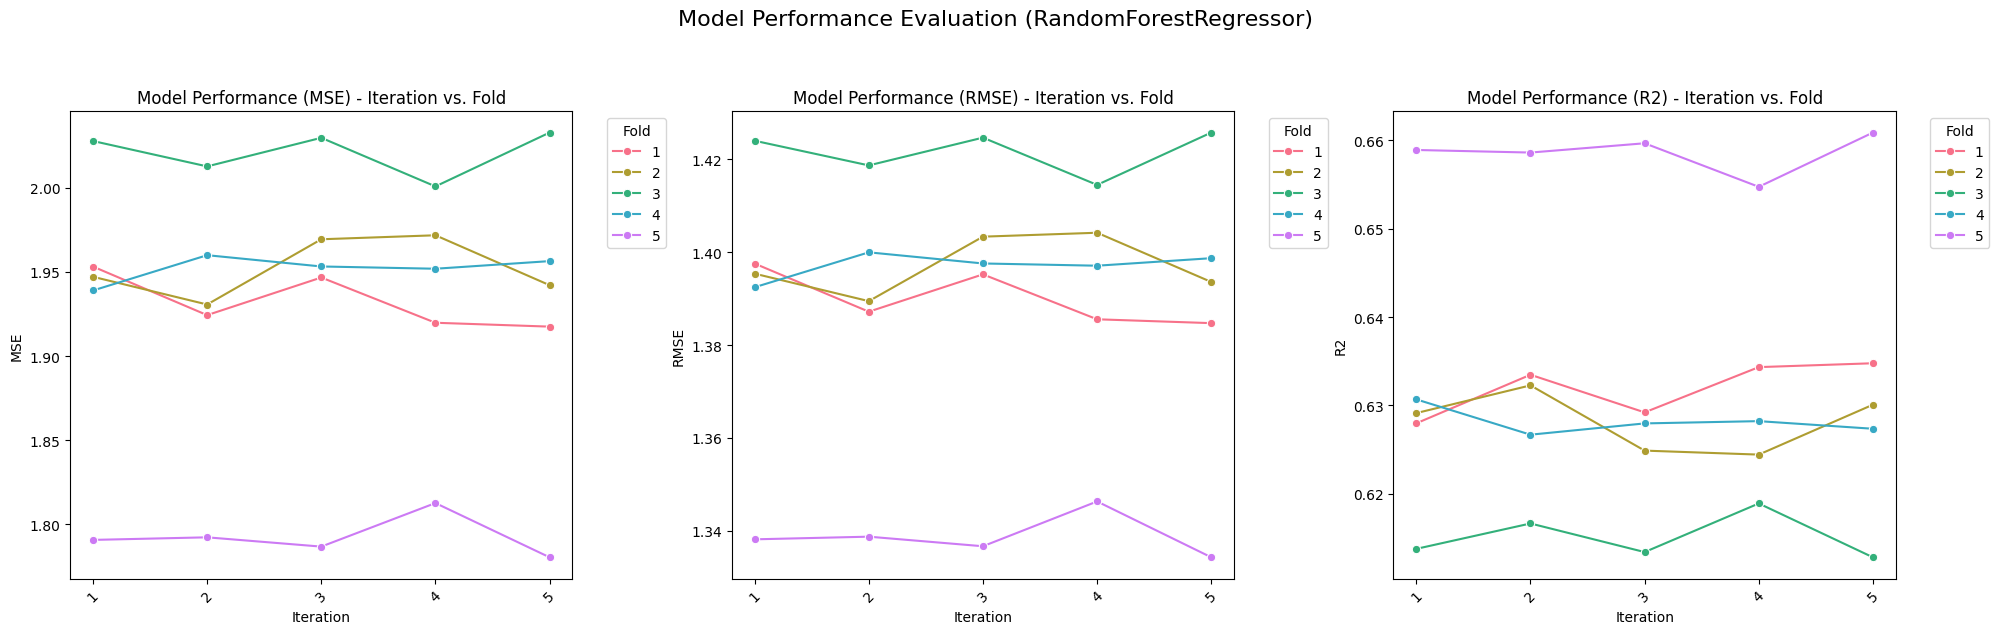

In [ ]:
plot_results(df_rf)

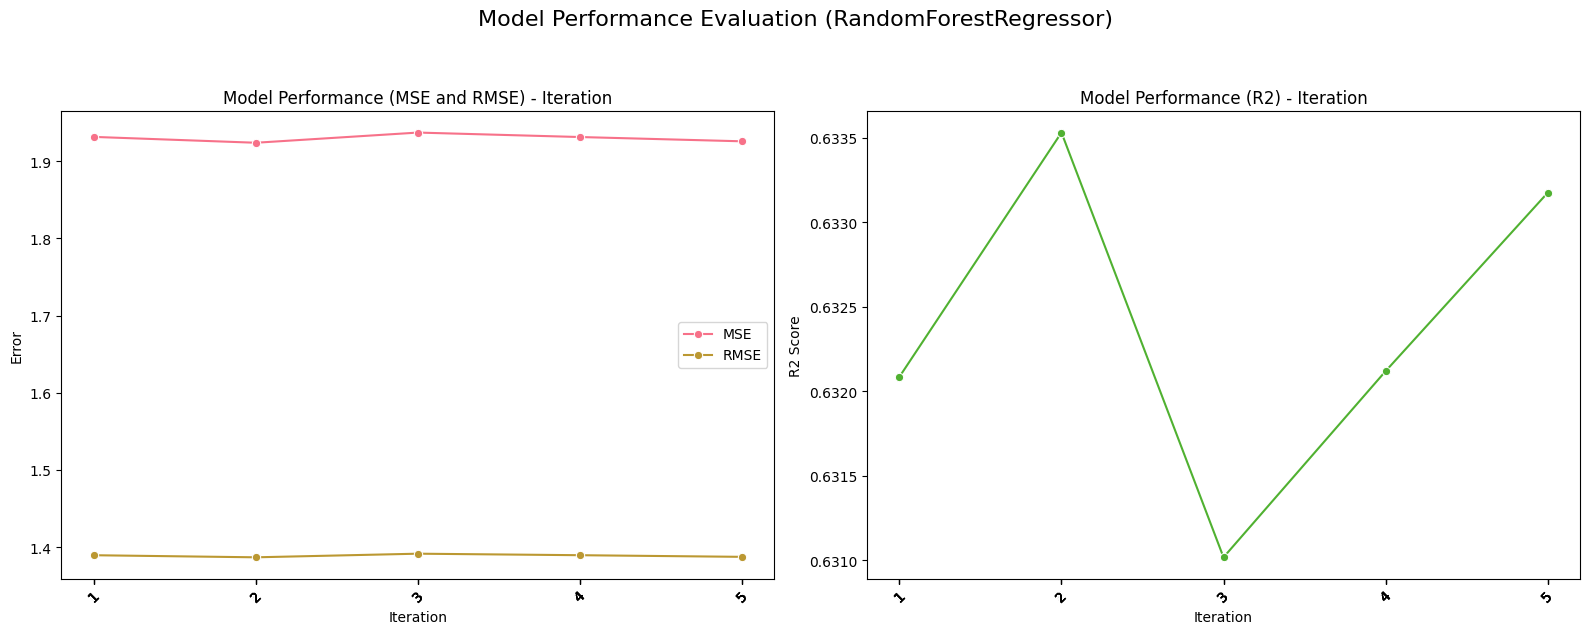

In [ ]:
plot_results_avg(df_rf_avg)

### LGBMRegressor Results

In [ ]:
df_lgbm

Model  Fold       MSE      RMSE  R2 Score  Iteration
0   LGBMRegressor     1  1.631015  1.277112  0.689331          1
1   LGBMRegressor     2  1.623046  1.273988  0.690848          1
2   LGBMRegressor     3  1.563538  1.250415  0.702183          1
3   LGBMRegressor     4  1.553692  1.246472  0.704059          1
4   LGBMRegressor     5  1.487746  1.219732  0.716620          1
5   LGBMRegressor     1  1.631015  1.277112  0.689331          2
6   LGBMRegressor     2  1.623046  1.273988  0.690848          2
7   LGBMRegressor     3  1.563538  1.250415  0.702183          2
8   LGBMRegressor     4  1.553692  1.246472  0.704059          2
9   LGBMRegressor     5  1.487746  1.219732  0.716620          2
10  LGBMRegressor     1  1.631015  1.277112  0.689331          3
11  LGBMRegressor     2  1.623046  1.273988  0.690848          3
12  LGBMRegressor     3  1.563538  1.250415  0.702183          3
13  LGBMRegressor     4  1.553692  1.246472  0.704059          3
14  LGBMRegressor     5  1.487746  1.219732  0.716620          3
15  LGBMRegressor     1  1.631015  1.277112  0.689331          4
16  LGBMRegressor     2  1.623046  1.273988  0.690848          4
17  LGBMRegressor     3  1.563538  1.250415  0.702183          4
18  LGBMRegressor     4  1.553692  1.246472  0.704059          4
19  LGBMRegressor     5  1.487746  1.219732  0.716620          4
20  LGBMRegressor     1  1.631015  1.277112  0.689331          5
21  LGBMRegressor     2  1.623046  1.273988  0.690848          5
22  LGBMRegressor     3  1.563538  1.250415  0.702183          5
23  LGBMRegressor     4  1.553692  1.246472  0.704059          5
24  LGBMRegressor     5  1.487746  1.219732  0.716620          5

In [ ]:
df_lgbm_avg

Model  Iteration       MSE      RMSE  R2 Score
0  LGBMRegressor          1  1.571807  1.253544  0.700608
1  LGBMRegressor          2  1.571807  1.253544  0.700608
2  LGBMRegressor          3  1.571807  1.253544  0.700608
3  LGBMRegressor          4  1.571807  1.253544  0.700608
4  LGBMRegressor          5  1.571807  1.253544  0.700608

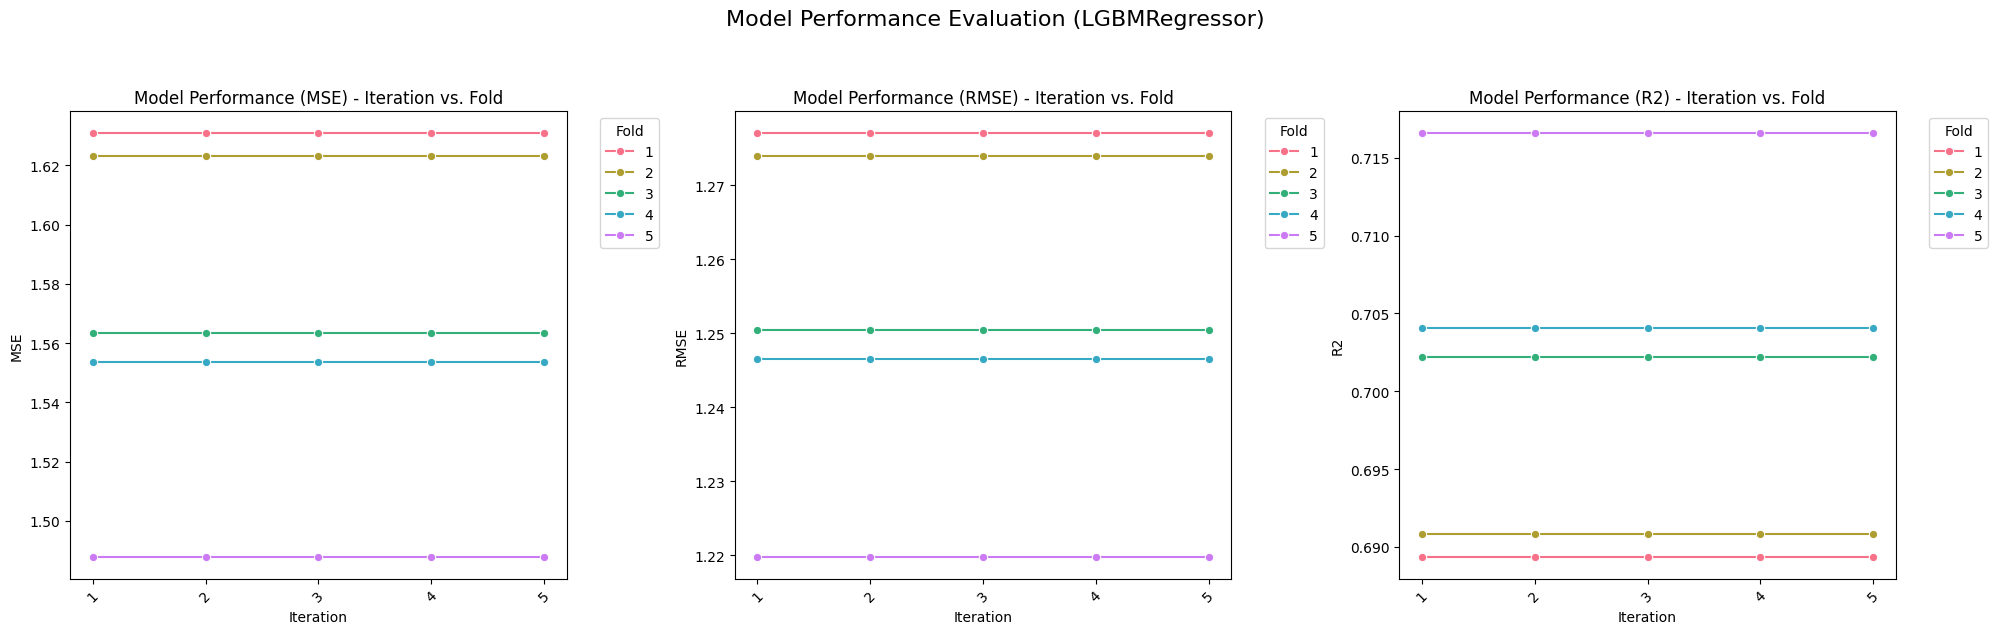

In [ ]:
plot_results(df_lgbm)

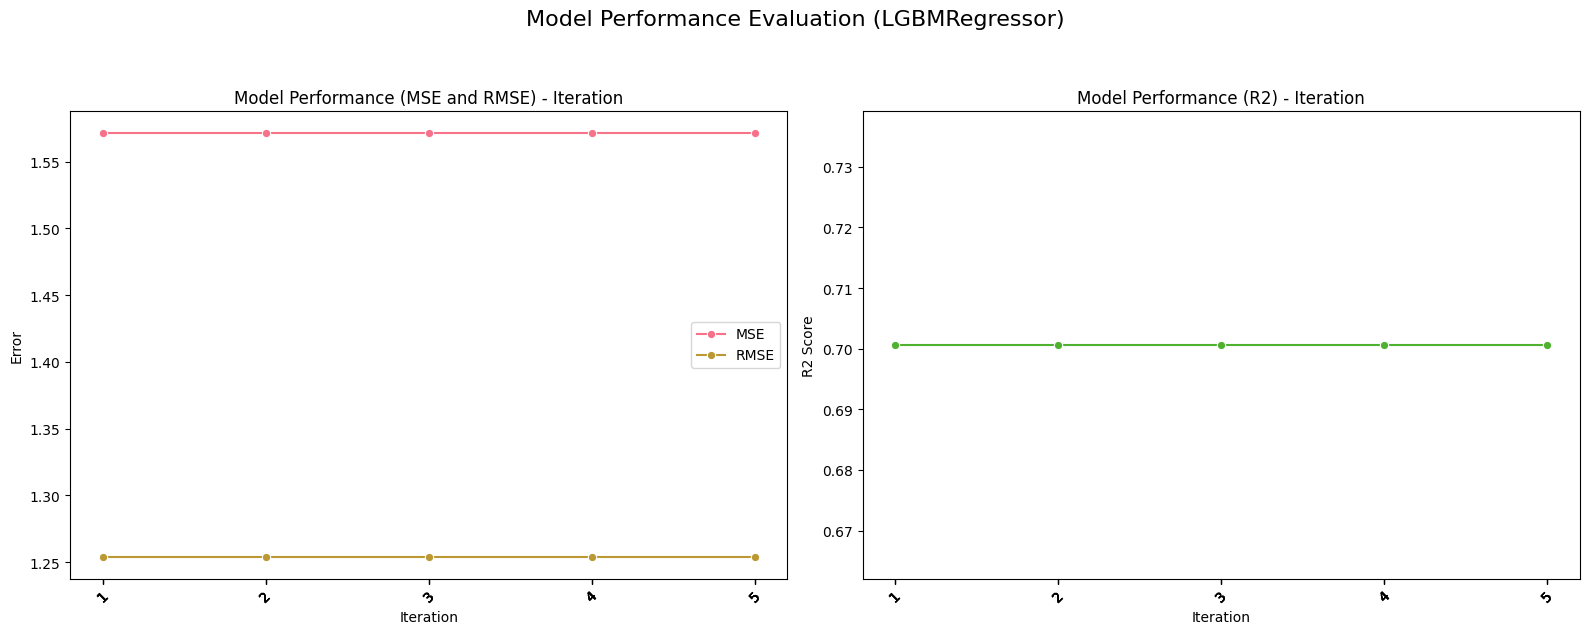

In [ ]:
plot_results_avg(df_lgbm_avg)

### SVM Results

In [ ]:
df_svm

Model  Fold       MSE      RMSE  R2 Score  Iteration
0    SVR     1  1.335060  1.155448  0.745703          1
1    SVR     2  1.394070  1.180707  0.734463          1
2    SVR     3  1.391540  1.179636  0.734945          1
3    SVR     4  1.303299  1.141621  0.751753          1
4    SVR     5  1.309408  1.144294  0.750589          1
5    SVR     1  1.335060  1.155448  0.745703          2
6    SVR     2  1.394070  1.180707  0.734463          2
7    SVR     3  1.391540  1.179636  0.734945          2
8    SVR     4  1.303299  1.141621  0.751753          2
9    SVR     5  1.309408  1.144294  0.750589          2
10   SVR     1  1.335060  1.155448  0.745703          3
11   SVR     2  1.394070  1.180707  0.734463          3
12   SVR     3  1.391540  1.179636  0.734945          3
13   SVR     4  1.303299  1.141621  0.751753          3
14   SVR     5  1.309408  1.144294  0.750589          3
15   SVR     1  1.335060  1.155448  0.745703          4
16   SVR     2  1.394070  1.180707  0.734463          4
17   SVR     3  1.391540  1.179636  0.734945          4
18   SVR     4  1.303299  1.141621  0.751753          4
19   SVR     5  1.309408  1.144294  0.750589          4
20   SVR     1  1.335060  1.155448  0.745703          5
21   SVR     2  1.394070  1.180707  0.734463          5
22   SVR     3  1.391540  1.179636  0.734945          5
23   SVR     4  1.303299  1.141621  0.751753          5
24   SVR     5  1.309408  1.144294  0.750589          5

In [ ]:
df_svm_avg

Model  Iteration       MSE      RMSE  R2 Score
0   SVR          1  1.346675  1.160341   0.74349
1   SVR          2  1.346675  1.160341   0.74349
2   SVR          3  1.346675  1.160341   0.74349
3   SVR          4  1.346675  1.160341   0.74349
4   SVR          5  1.346675  1.160341   0.74349

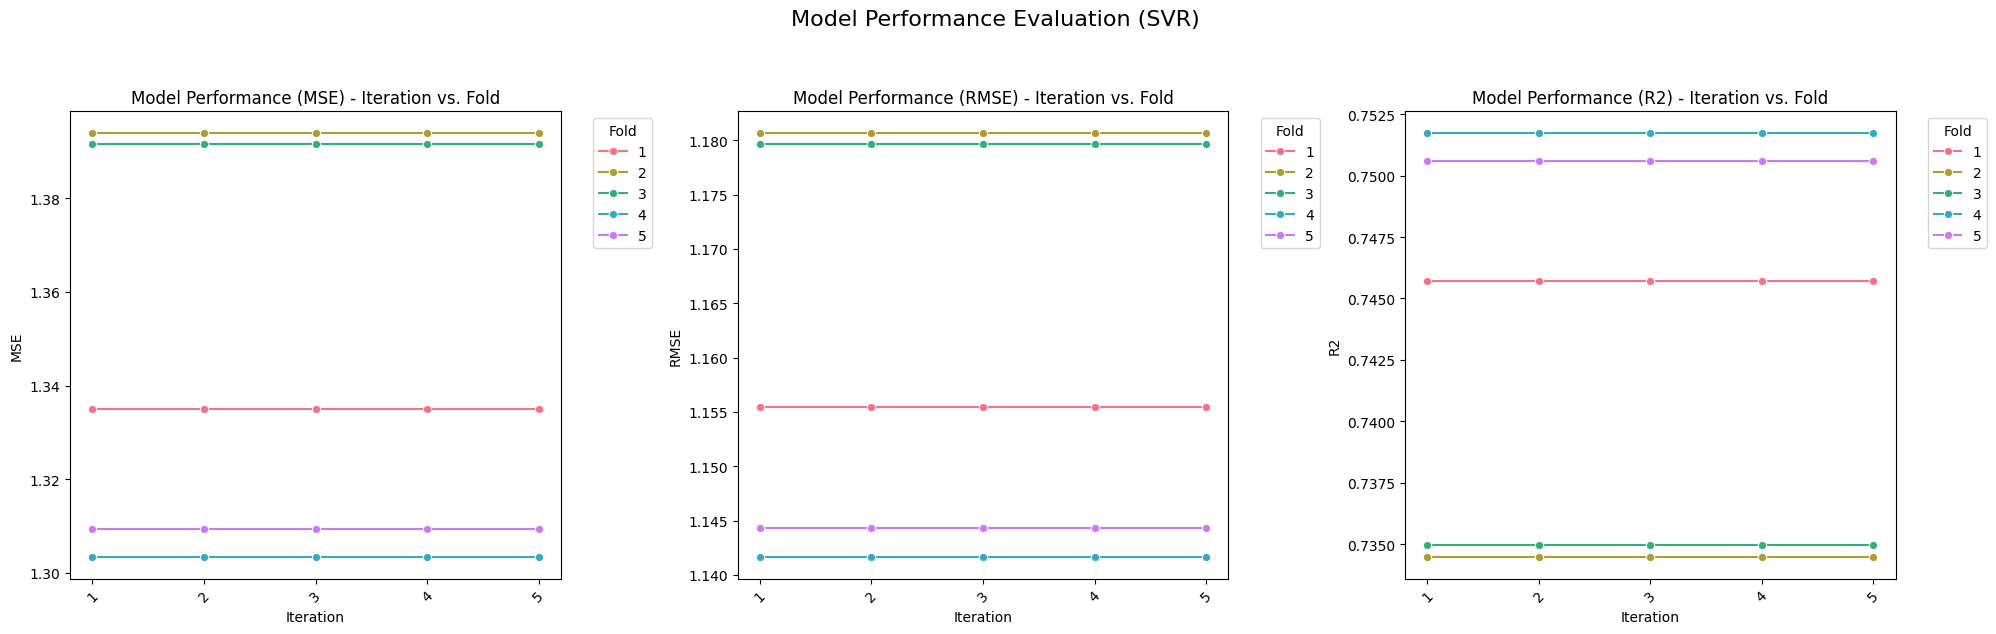

In [ ]:
plot_results(df_svm)

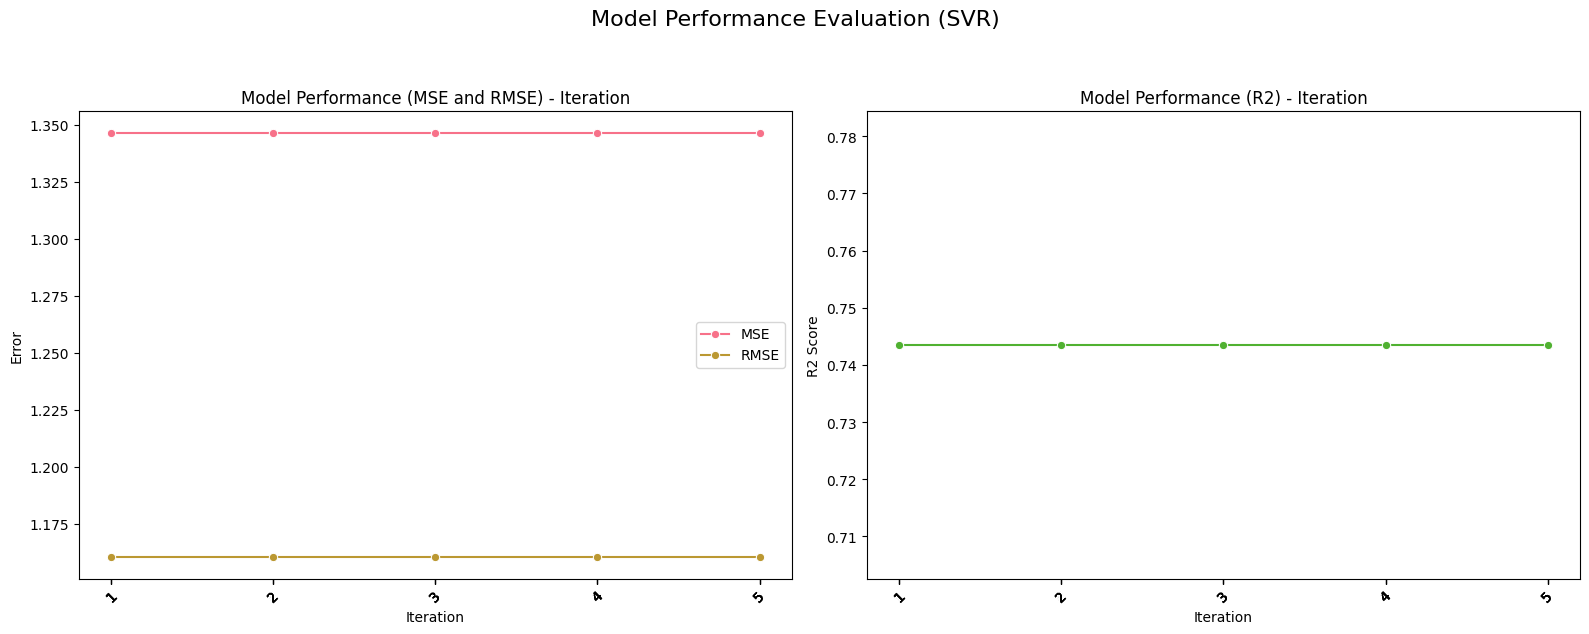

In [ ]:
plot_results_avg(df_svm_avg)

In [ ]:
final_res = pd.concat([df_rf_avg, df_lgbm_avg, df_svm_avg]).reset_index(drop=True)
final_res

Model  Iteration       MSE      RMSE  R2 Score
0   RandomForestRegressor          1  1.931555  1.389520  0.632085
1   RandomForestRegressor          2  1.923970  1.386819  0.633530
2   RandomForestRegressor          3  1.937161  1.391510  0.631017
3   RandomForestRegressor          4  1.931381  1.389541  0.632118
4   RandomForestRegressor          5  1.925842  1.387425  0.633173
5           LGBMRegressor          1  1.571807  1.253544  0.700608
6           LGBMRegressor          2  1.571807  1.253544  0.700608
7           LGBMRegressor          3  1.571807  1.253544  0.700608
8           LGBMRegressor          4  1.571807  1.253544  0.700608
9           LGBMRegressor          5  1.571807  1.253544  0.700608
10                    SVR          1  1.346675  1.160341  0.743490
11                    SVR          2  1.346675  1.160341  0.743490
12                    SVR          3  1.346675  1.160341  0.743490
13                    SVR          4  1.346675  1.160341  0.743490
14                    SVR          5  1.346675  1.160341  0.743490

In [ ]:
# Calculate average MSE, RMSE, and R2 Score for each model
avg_metrics = final_res.groupby("Model").mean()[['MSE', 'RMSE', 'R2 Score']]

print("Average Metrics:")
avg_metrics

Average Metrics:


MSE      RMSE  R2 Score
Model                                              
LGBMRegressor          1.571807  1.253544  0.700608
RandomForestRegressor  1.929982  1.388963  0.632384
SVR                    1.346675  1.160341  0.743490

In [ ]:
# Determine the best model based on the highest average R2 Score
best_model_r2 = avg_metrics['R2 Score'].idxmax()
print("Best Model based on R2 Score:", best_model_r2)

Best Model based on R2 Score: SVR


## To determine the best model based on the provided average metrics (MSE, RMSE, and R2 Score), we'll look for the model with the lowest average MSE and RMSE, as well as the highest average R2 Score.

## Based on the provided averages:

* MSE: SVR has the lowest average MSE of 1.346675.
* RMSE: SVR has the lowest average RMSE of 1.160341.
* R2 Score: SVR has the highest average R2 Score of 0.743490.

### **Therefore, SVR outperforms both LGBMRegressor and RandomForestRegressor across all three metrics. Thus, SVR is the best-performing model among the three based on the provided average metrics.**

# <font color='magma'> **Train Deep Learning Model (DenseNet201)**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
image_data = np.load('/content/drive/MyDrive/Hands Dataset/images.npy')
labels = np.load('/content/drive/MyDrive/Hands Dataset/labels.npy')

In [ ]:
image_data.shape

(6360, 50, 50, 3)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the Data
image_data = np.load('/content/drive/MyDrive/Hands Dataset/images.npy')
labels = np.load('/content/drive/MyDrive/Hands Dataset/labels.npy')

# Normalize the image data
image_data = image_data / 255.0

In [ ]:
import random
random.seed(42)

In [ ]:
# Split the data into training and testing sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=0, stratify=labels)

In [ ]:
# Build the DenseNet Model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add custom layers for regression
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1)(x)

# Combine base model and custom layers
model = Model(inputs=base_model.input, outputs=predictions)

74836368/74836368 [==============================] - 4s 0us/step


In [ ]:
import tensorflow.keras.backend as K

# Define R^2 Score as a custom metric
def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())

# Compile the Model with MSE loss and R^2 Score metric
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=[r_squared])

In [ ]:
# Train the Model
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
159/159 [==============================] - 134s 173ms/step - loss: 42.0050 - r_squared: -7.4146 - val_loss: 43.3594 - val_r_squared: -7.5553
Epoch 2/20
159/159 [==============================] - 22s 139ms/step - loss: 2.1091 - r_squared: 0.5718 - val_loss: 13.8181 - val_r_squared: -1.7102
Epoch 3/20
159/159 [==============================] - 22s 138ms/step - loss: 1.2904 - r_squared: 0.7391 - val_loss: 22.7888 - val_r_squared: -3.4847
Epoch 4/20
159/159 [==============================] - 23s 142ms/step - loss: 1.1327 - r_squared: 0.7718 - val_loss: 9.0603 - val_r_squared: -0.7706
Epoch 5/20
159/159 [==============================] - 22s 141ms/step - loss: 1.1024 - r_squared: 0.7779 - val_loss: 41.0266 - val_r_squared: -7.1158
Epoch 6/20
159/159 [==============================] - 22s 138ms/step - loss: 1.0291 - r_squared: 0.7923 - val_loss: 13.2843 - val_r_squared: -1.6025
Epoch 7/20
159/159 [==============================] - 23s 145ms/step - loss: 0.9179 - r_squared: 0.8130 

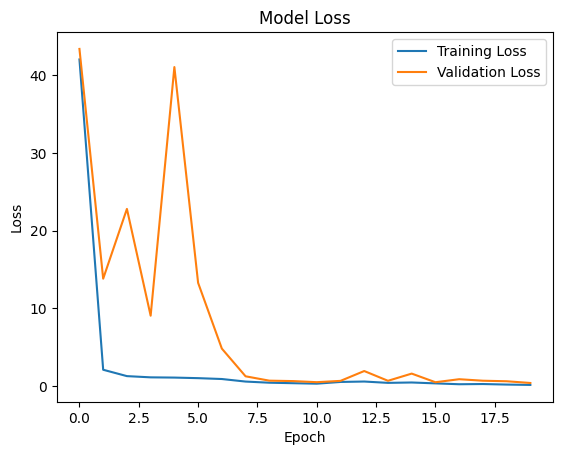

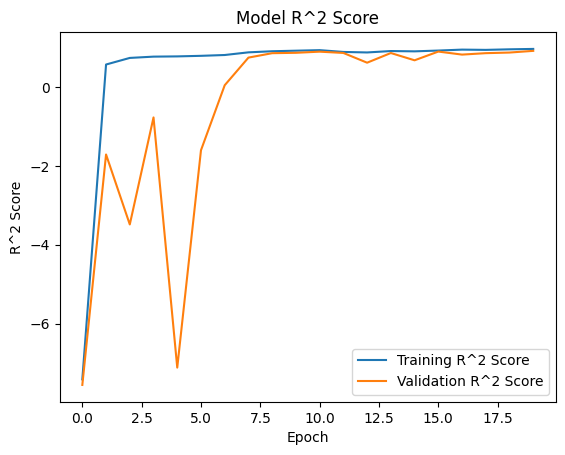

In [ ]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation R^2 Score
plt.plot(history.history['r_squared'], label='Training R^2 Score')
plt.plot(history.history['val_r_squared'], label='Validation R^2 Score')
plt.title('Model R^2 Score')
plt.xlabel('Epoch')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()

In [ ]:
# Evaluate the Model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

40/40 [==============================] - 1s 31ms/step - loss: 0.4084 - r_squared: 0.9182
Test Loss: [0.4084254205226898, 0.9182177782058716]


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Make predictions on the test data
predictions = model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R^2 Score
r2 = r2_score(y_test, predictions)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R^2 Score:", r2)

40/40 [==============================] - 4s 23ms/step
Mean Squared Error (MSE): 0.4084254197675547
Root Mean Squared Error (RMSE): 0.6390817003854473
R^2 Score: 0.9222046819490373
